<a href="https://colab.research.google.com/github/nnguyenu/ML-basic/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [ ]:
NAME = ""
COLLABORATORS = ""

---

# CSE204 - Introduction to Machine Learning - Lab Session 10: Dimensionality Reduction with PCA and Autoencoders

<img src="https://raw.githubusercontent.com/adimajo/polytechnique-cse204-2019-releases/master/logo.jpg" style="float: left; width: 15%" />

[CSE204-2019](https://moodle.polytechnique.fr/course/view.php?id=7862) Lab session #10

J.B. Scoggins - Adrien Ehrhardt

[![Open in Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adimajo/polytechnique-cse204-2019-releases/blob/master/lab_session_10/lab_session_10.ipynb)

[![My Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/adimajo/polytechnique-cse204-2019-releases/master?filepath=lab_session_10%2Flab_session_10.ipynb)

[![Local](https://img.shields.io/badge/Local-Save%20As...-blue)](https://github.com/adimajo/polytechnique-cse204-2019-releases/raw/master/lab_session_10/lab_session_10.ipynb)

## Introduction

In this lab, you will get hands-on experience with dimension reduction using two separate techniques: Priciple Component Analysis and Undercomplete Autoencoders.  The goal of dimension reduction is to find a suitable transformation which converts a large dimensional space into a smaller feature space, such that the important information is not lost.

In [ ]:
colab_requirements = [
    "matplotlib>=3.1.2",
    "pandas>=0.25.3",
    "numpy>=1.18.1",
    "scikit-learn>=0.22.1",
    "nose>=1.3.7",
    "tensorflow>=2.1.0"
]
import sys, subprocess
def run_subprocess_command(cmd):
    # run the command
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    # print the output
    for line in process.stdout:
        print(line.decode().strip())
        
if "google.colab" in sys.modules:
    for i in colab_requirements:
        run_subprocess_command("pip install " + i)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 KB 3.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow.keras.datasets.mnist as mnist
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model
import numpy as np

## Step 1: Recall the MNIST Dataset

We will use the MNIST digits dataset throughout this excercise.  Recall from your previous labs that the MNIST dataset provides 60000 28x28 pixel grayscale training images of hand-written digits 0-9.  The images are labeled with integer values 0-9.  The training set has become the defacto image classification example due to its small size.  

In this excercise, we are not interested in classifying images of digits.  Instead, we will think of the images as defining a 28x28 = 784 element feature space.  In this context, we are interested in transforming the 784 parameters into a smaller set of transformed coordinates.  

**Exercise 1.1:** Before continuing to the next section, use the keras datasets module to load the MNIST dataset and get to know how it is structured.

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test  = x_test / 255.0

- Inspect the dataset. What is the shape of x_train and y_train?

In [ ]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

- Plot a few images using matplotlib.pyplot to see what they look like.

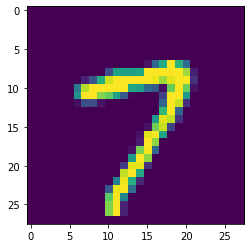

In [ ]:
plt.imshow(x_train[103])

## Step 2: Principle Component Analysis (PCA)

The goal of PCA is to perform an orthogonal transformation which converts a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables, called _principle components_.  This can be thought of as fitting an n-dimensional ellipsoid to the observations.  

Let's consider a dataset $X\in R^{n\times p}$, where $n$ is the number of observations and $p$ the number of variables.  PCA transforms $X$ into a new coordinate system (new variable set), such that the greatest variance in the data is captured in the first coordinate, and then the second, and so on.  More specifically, the transformed coordinates $T \in R^{n\times p}$ are written as a linear combination of the original dataset,

$$ T = X W, $$

where $W \in R^{p\times p}$ is the transformation matrix.  The first column of $W$, denoted as $w_1$, is constructed to maximize the variance of the transformed coordinates.

$$ w_1 = \underset{\|w\|=1}{\operatorname{argmax}} \sum_{i=1}^{n} (t_1)_i^2 = \underset{\|w\|=1}{\operatorname{argmax}} \| X w \|_2^2 = \underset{\|w\|=1}{\operatorname{argmax}} \frac{w^T X^T X w}{w^T w} $$

The ratio in the last term is known as the _Rayleigh quotient_.  It is well known that for the positive, semidefinite matrix $X^T X$, the largest value of the Rayleigh quotient is given as the largest eigenvalue of the matrix, where $w$ is eigenvector associated with that eigenvalue.

The remaining columns of $W$ can be found by finding the the next orthogonal linear combination which maximizes the variance of the data, minus the previously transformed coordinates.

$$ w_k = \underset{\|w\|=1}{\operatorname{argmax}} \| (X - \sum_{s=1}^{k-1} X w_s w_s^T) w \|^2_2 $$

Practically, the columns of $W$ are typically computed as the eigenvectors of $X^T X$ ordered by their corresponding eigenvalues in descending order.

### Singular Value Decomposition

The Singular Value Decomposition of a matrix $X \in R^{n\times p}$ is given as

$$ X = U \Sigma W^T, $$

where $\Sigma \in R^{n\times p}$ is a rectangular diagonal matrix of positive values known as the singular values of $X$, $\sigma(X)$, and $U \in R^{n\times n}$ and $W \in R^{p\times p}$ are orthonormal matrices, whose columns are the left and right (respectively) singular vectors of the matrix $X$.  Using this decomposition, we can easily see that

$$ X^T X = W \hat{\Sigma} W^T, $$

where $\hat{\Sigma}$ is a square diagonal matrix of the squared singular values of $X$.  Comparing this to the eigenvalue decomposition of $X^T X = Q \Lambda Q^T$, we see that the singular values of $X$ represent the square-root of the eigenvalues of $X^T X$, and the singular vectors of $X$ are simply the eigenvectors of $X^T X$.  Therefore, we can perform PCA on a data matrix $X$ by computing its right singular vector matrix, $W$.

### Dimensionality Reduction

We can reduce the dimensionality of our data by truncating the transformed variables to include only a subset of those variables with the highest variance.  For example, if we keep the first $L <= p$ variables, the reduced transformation reads

$$ T_L = X W_L, $$

where $W_L \in R^{n\times L}$ is the eigenvector matrix as before, but taking only the first $L$ columns.  This technique has been widely used to reduce the dimension of large-dimensioned datasets by accounting for the directions of largest variance in the data, while neglecting the other directions.  In addition, this can also be used to remove noise from a dataset, in which it is assumed that the noise accounts for a small degree of variance, compared to the true underlying parameterization.  Finally, using PCA to find the 2 highest varying parameters can also allow us to visualize a high-dimensional dataset.  

**Exercise 2.1:** Visualize the MNIST dataset in 2 dimensions.

- Use numpy to [compute the SVD](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html) of the MNIST images.  Note, you will first need to reshape the array to 2D with n = 60000 and p = 28 x 28 = 784.
- Compute the first two principle components by truncating the eigenvector matrix before multiplying by the data array.
- Plot the two principle components on a scatter plot with matplotlib.pyplot.scatter, using the image labels to color the markers. (Hint: it might be easier to see if you plot fewer points)
- What do you notice about the how the data is presented in the plot?
- Which images form a tight cluster in the reduced space?

In [ ]:
N = 60000
X_train = np.reshape(x_train, (N,-1))
y_train = np.reshape(y_train, (N, -1))

u, s, w = np.linalg.svd(X_train[:10000])

In [ ]:
T = X_train.dot(w[:, :2])
print(T.shape, u.shape, s.shape, w.shape)

(60000, 2) (10000, 10000) (784,) (784, 784)


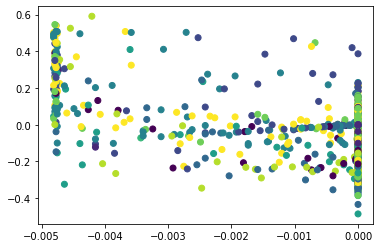

In [ ]:
points = 5000
plt.scatter(T[:points,0], T[:points,1], c = y_train[:points])

### Scree Plot

It is not always clear how many principle components are necessary to accurately represent the high-dimensional space.  There are two widely used methods to help us get a sense of the number variables required.  The first is called a Scree plot, which plots the eigenvalues of $X^T X$ in descending order.  Since the eigenvalues represent the degree of variance in the corresponding principle components, such a plot can tell use how many components are needed before we reach diminishing returns.

**Exercise 2.2:** Plot the Scree plot for the MNIST data.
- How many principle components are needed to represent most of the variance.

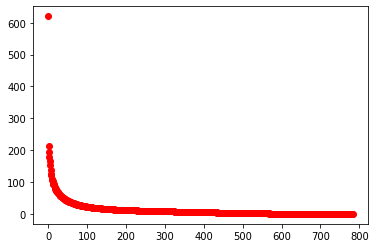

In [ ]:
plt.plot(s,'ro')

### Total Variance Explained

Another method is called _Total Variance Explained_.  In this method, we plot the cumulative sum of the eigenvalues and choose the number of components which give us a certain percentage fo the total variance.

**Exercise 2.3:** Plot the cumulative sum of the eigenvalues.
- Plot a horizontal line at 95% of the total sum.
- Based on this, how many components are needed to capture 95% of the variance?
- How does this compare to the Scree plot result?

9496.26457134836
419 9495.191829699581 9500.065156065883


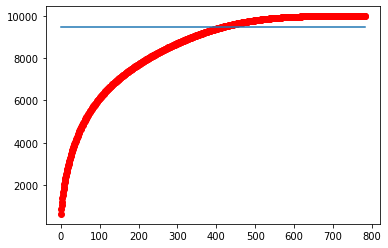

In [ ]:
pres = np.cumsum(s)
plt.plot(pres,'ro')
val = np.sum(s) * 0.95
print(val)
plt.plot(np.arange(784),[val]*784)
component_need = np.searchsorted(pres, val)
print(component_need, pres[component_need-1], pres[component_need])

### Reconstruct Images

Now that we have an idea of how many principle components are necessary, let's use them to encode the images in a smaller set of features, which we can then decode to reconstruct the images from the lower-dimensional space.  Recall that based on the PCA transformation, we can compute the reconstructed images with

$$ \hat{X} = (X W_L) W_L^T $$

**Exercise 2.4:** Plot original and reconstruct images.
- Create a grid of images using pyplot.subplots and imshow.
  - In the first row, plot the first 5 images of the dataset.
  - In the next 4 rows, plot reconstructions of the images using the first 5, 15, 30, and 100 principle component vectors.
- How do the reconstructed images compare with the originals as you increase the size of the reduced space?

Note that once we have computed the transformation matrix $W$, we essentially have a compression scheme to convert our images into a compressed format.  From this perspective, using the first 5, 10, 30, and 100 principle components is equivalent to compressing the data at a rate of 156:1, 78:1, 26:1, and 8:1, respectively.  By contrast, JPEG image compression can obtain compression ratios of 23:1 with reasonable image quality, surpassing the quality of reconstructions with PCA.  For that reason, PCA is not really used for image compression, but it has been used in a number of other fields, particularly in physics and engineering.


In [ ]:
# First create some toy data:
x = np.linspace(0, 2*np.pi, 400)
y = np.sin(x**2)

# Create just a figure and only one subplot
fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_title('Simple plot')

# Create two subplots and unpack the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(x, y)
ax1.set_title('Sharing Y axis')
ax2.scatter(x, y)

# Create four polar axes and access them through the returned array
fig, axs = plt.subplots(2, 2, subplot_kw=dict(projection="polar"))
axs[0, 0].plot(x, y)
axs[1, 1].scatter(x, y)

# Share a X axis with each column of subplots
plt.subplots(2, 2, sharex='col')

# Share a Y axis with each row of subplots
plt.subplots(2, 2, sharey='row')

# Share both X and Y axes with all subplots
plt.subplots(2, 2, sharex='all', sharey='all')

# Note that this is the same as
plt.subplots(2, 2, sharex=True, sharey=True)

# Create figure number 10 with a single subplot
# and clears it if it already exists.
fig, ax = plt.subplots(num=10, clear=True)

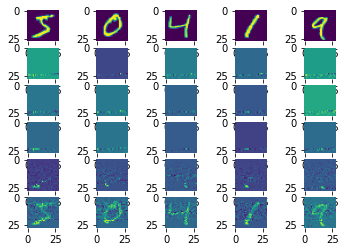

In [84]:
component_vec = [5, 15, 30, 100, 419]
image_sample = 5

for i in range(image_sample):
    ax = plt.subplot(len(component_vec)+1, image_sample, i+1, frame_on=False) 
    ax = plt.imshow(X_train[i].reshape((28,28)))

for id, L in enumerate(component_vec):
    W = w[:,:L]
    Xhat = X_train.dot(W).dot(W.T)
    for i in range(image_sample):
        ax = plt.subplot(len(component_vec)+1, image_sample, (id+1)*5+i+1, frame_on=False) 
        ax = plt.imshow(Xhat[i].reshape((28,28)))

## Step 3: Autoencoders

In this next part, we will devise a compression strategy using another method, autoencoders.  Autoencoders are neural networks which are trained to output their input in such a way that they learn a reduced dimensional space of the input distribution.  They are general composed of two distinct layers. The first encodes the input space (encoder) and the second decodes the encoded space back to the original feature space (decoder).  There are 3 basic types of autoencoders:
1. __Undercomplete__ autoencoders work by constructing a network that has a hidden code layer that has fewer nodes than the input and output layers.  After training, the smaller hidden layer will represent an encoding of the input onto a lower dimensional space.
2. __Regularized__ autoencoders use various regularization terms in the loss function during training to constrict the space of the output.  For example, sparse autoencoders add a sparsity regularization term in the loss to force as many nodes in the hidden layers to be zero.
3. __Variational__ autoencoders work slightly differently than the previous two.  In this case, the autoencoder learns parameters that model the distribution of the input data in the encoder.  The decoder is then used to reconstruct the output based on a random sample from this distribution.  Some variational autoencoders have been used for image generation. 

In this exercise, we will construct two undercomplete autoencoders and train them on the MNIST data as before.

### Dense linear decoder

It is well known that an autoencoder with a linear decoder layer and a mean-squared-error loss function will learn the same feature space as PCA.  Let's check this by creating a simple linear autoencoder.

**Exercise 3.1:** Create a simple linear autoencoder.

- Write a funtion which takes the `input_size` and the `code_size` and returns an autoencoder model using Keras.
  - The autoencoder should be comprised of
    - A dense encoder layer taking `input_size` inputs with `code_size` nodes and ReLU activation.
    - A linear decoder layer with `input_size` nodes.
  - Compile the model using the Adam optimizer and MSE loss
  - In addition to the autoencoder, return another model which just takes the input and returns the output of the encoder layer.  For hints, see the [functional API documentation](https://keras.io/getting-started/functional-api-guide/).
 

In [110]:
def linear_autoencoder(input_size, code_size):
    input_img = Input(shape=(input_size,))
    encode = Dense(code_size, activation="relu")(input_img)
    decode = Dense(input_size, activation="relu")(encode)
    autoencoder = Model(input_img, decode)
    encoder = Model(input_img, encode)
    autoencoder.compile(optimizer='adam', loss='MeanSquaredError')
    return autoencoder, encoder

**Exercise 3.2:** Train the autoencoder.

- Using your function, create a linear autoencoder with `input_size` = 784 and `reduced_size` = 2.
- Train the model using the MNIST data as input and output for 5 epochs.
- Plot the history of the loss versus the epoch number to make sure training is basically complete.

In [111]:
autoencoder, encoder = linear_autoencoder(784, 2)
history = autoencoder.fit(X_train, y_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 11.7145
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 10.1600
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 10.0073
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 9.9118
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 9.7869
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 9.7158
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 9.6701
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 9.6348
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 9.6098
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 9.5862


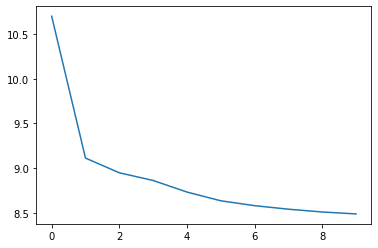

In [103]:
plt.plot(np.arange(0, 10), history.history['loss'])

**Exercise 3.3:** Use the trained encoder to encode the MNIST data to 2 variables.
- Plot the two components in a scatter plot as with the PCA result.
- How does the scatter plot compare to the one you made with PCA?  Recall that this autoencoder should learn the same vector space as PCA, though it will not learn the exact same transformation (could be rotated, scaled, etc.).

1875/1875 [==============================] - 3s 2ms/step


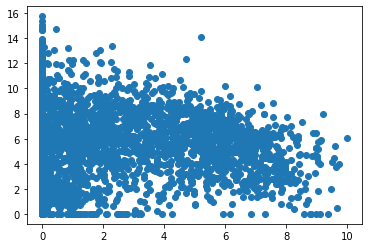

In [115]:
newX = encoder.predict(X_train)
plt.scatter(newX[:5000,0], newX[:5000,1])

### Nonlinear Decoder

We saw in the previous section that linear decoders and MSE loss produce the same result as PCA.  Therefore, we can see nonlinear decoders as a nonlinear generalization of PCA.  By allowing nonlinear transformations, we should be able to increase the expressiveness of our reduced variables.  

**Exercise 3.4:** Create a nonlinear autoencoder.

- Copy your linear autoencoder function, naming it differently to produce a nonlinear AE.
- Add a dense hidden layer in between the encoder output and decoder output layers.  Give the hidden layer `input_size`/2 nodes and use ReLU activation.

In [116]:
def nonlinear_autoencoder(input_size, code_size):
    input_img = Input(shape=(input_size,))
    encode = Dense(code_size, activation="relu")(input_img)
    middle = Dense(input_size/2, activation="relu")(encode)
    decode = Dense(input_size, activation="relu")(middle)
    autoencoder = Model(input_img, decode)
    encoder = Model(input_img, encode)
    autoencoder.compile(optimizer='adam', loss='MeanSquaredError')
    return autoencoder, encoder

**Exercise 3.5:** Train nonlinear reduced model.
- Create the nonlinear AE using 2 variables as with the linear model.
- Train as before and plot the loss history.

In [124]:
autoencoder, encoder = nonlinear_autoencoder(784, 2)
history = autoencoder.fit(X_train, y_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 15s 8ms/step - loss: 8.7389
Epoch 2/10
1875/1875 [==============================] - 15s 8ms/step - loss: 7.4656
Epoch 3/10
1875/1875 [==============================] - 14s 8ms/step - loss: 7.2021
Epoch 4/10
1875/1875 [==============================] - 15s 8ms/step - loss: 6.9662
Epoch 5/10
1875/1875 [==============================] - 15s 8ms/step - loss: 6.6942
Epoch 6/10
1875/1875 [==============================] - 15s 8ms/step - loss: 6.5755
Epoch 7/10
1875/1875 [==============================] - 14s 8ms/step - loss: 6.1578
Epoch 8/10
1875/1875 [==============================] - 14s 8ms/step - loss: 5.9555
Epoch 9/10
1875/1875 [==============================] - 15s 8ms/step - loss: 5.6043
Epoch 10/10
1875/1875 [==============================] - 14s 8ms/step - loss: 5.2715


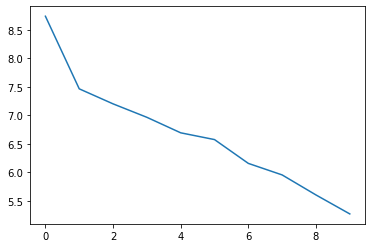

In [125]:
plt.plot(np.arange(0, 10), history.history['loss'])

**Exercise 3.6:** Plot the scatter plot of the reduced variables.
- What can you say about grouping of points using the nonlinear model?  Does it seem to cluster the digits better than with the linear one? (If it doesn't look any better, try training the model again.)

1875/1875 [==============================] - 4s 2ms/step


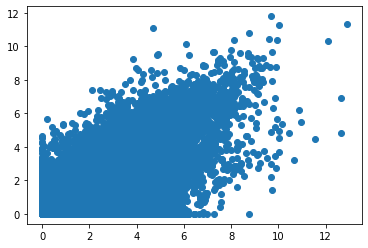

In [128]:
newX = encoder.predict(X_train)
plt.scatter(newX[:,0], newX[:,1])

### Reconstruct Images

**Exercise 3.7:** Use the autoencoders to produce reconstructed images from the MNIST data as we did with PCA.
- Train linear and nonlinear autoencoders on the MNIST data using a `reduced_size` of 15.
- Compare the loss histories of the training for both models on the same plot.  What does this tell you about the expressiveness of the two models?

In [129]:
auto1, encoder1 = linear_autoencoder(784,15)
auto2, encoder2 = nonlinear_autoencoder(784, 15)
history = auto1.fit(X_train, y_train, epochs=5)
history = auto2.fit(X_train, y_train, epochs=10)

**Exercise 3.8:** Use the two AEs to produce reconstructed images.
- Generate a grid of images
  - The first row should contain the first 5 images in the MNIST set as before.
  - The second row should contain their reconstruction using the linear model.
  - The third row shoudl contain the reconstructions using the nonlinear model.
- How well do each of the models reproduce the images? 
- How do they compare to the PCA reconstructions?

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()